# Preprocessing

First, we import all the modules, functions, and data required.

In [20]:
import os
import numpy as np
from matplotlib import pyplot as plt
import importlib
from tqdm import tqdm
import pickle

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

import aux_preprocessing as aux

In [3]:
week1data = aux._getstudies("Thorax_Abdomen/week1/DICOMDIR")
week2data = aux._getstudies("Thorax_Abdomen/week2/DICOMDIR")
week3data = aux._getstudies("Thorax_Abdomen/week3/DICOMDIR")
week4data = aux._getstudies("Thorax_Abdomen/week4/DICOMDIR")
week5data = aux._getstudies("Thorax_Abdomen/week5/DICOMDIR")
week6data = aux._getstudies("Thorax_Abdomen/week6/DICOMDIR")
week7data = aux._getstudies("Thorax_Abdomen/week7/DICOMDIR")

In [4]:
week22data = aux._getstudies("Thorax_Abdomen/week2_2/DICOMDIR")
week23data = aux._getstudies("Thorax_Abdomen/week2_3/DICOMDIR")
week24data = aux._getstudies("Thorax_Abdomen/week2_4/DICOMDIR")
week25data = aux._getstudies("Thorax_Abdomen/week2_5/DICOMDIR")
week32data = aux._getstudies("Thorax_Abdomen/week3_2/DICOMDIR")
week33data = aux._getstudies("Thorax_Abdomen/week3_3/DICOMDIR")
week72data = aux._getstudies("Thorax_Abdomen/week7_2/DICOMDIR")

## Understanding the data

Thorax_Abdomen contains the data collected during 7 weeks, and it is organized as:
 * Data (Thorax_Abdomen)
     * Week (week1, week2, etc.)
         * Scan ('E864M5E16Q', etc.)
             * Series
                 - Slice

All the data for a single week can be retrieved as follows:

In [21]:
week1data = aux._getstudies("Thorax_Abdomen/week1/DICOMDIR")

Each week contains several CT scans that are identified by a string, such as 'E864M5E1BQ'. These strings are the keys of the dictionary we just created:

In [22]:
week1scans = list(week1data.keys())
print(week1scans)

['E864M5E16Q', 'E864M5E19Q', 'E864M5E1BQ', 'E864M5E12Q', 'E864M5E1AP', 'E864M5E1AQ', 'E864M5E17Q', 'E864M5E14Q', 'E864M5E18Q', 'E864M5E13Q', 'E864M5E15Q']


Each of the CT scans in `week1data` contains all the data in a single-element list. We check that:

In [23]:
importlib.reload(aux)

aux.check_len1(week1data)

Everything ok!


Now, we keep a single scan, which corresponds to the data of this single-element list. It corresponds to a dictionary of series, which are identified by an integer:

In [24]:
scan0 = week1data['E864M5E14Q'][0]
scan0.keys()

dict_keys([8])

In [25]:
scan0series8 = scan0[8]

An individual dataset corresponds to an individual slice of the 3D CT scan:

In [26]:
slice0 = scan0series8[0]
print(slice0)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.73231.30000018101512203521200001678
(0008, 0020) Study Date                          DA: '20181015'
(0008, 0021) Series Date                         DA: '20181015'
(0008, 0022) Acquisition Date                    DA: '20181015'
(0008, 0023) Content Date                        DA: '20181015'
(0008, 002a) Acquisition DateTime                DT: '20181015134849.032000'
(0008, 0030) Study Time                          TM: '134018.000000'
(0008, 0031) Series Time                         TM: '134921.933000'
(0008, 0032) Acquisition Time                    TM: '134849.032000'
(0008, 0033) Content Time                        TM: '134849.032000'
(0008, 0050) Accession Number                

In [43]:
# Note that the dose is SLICE-DEPENDENT
slice100 = scan0series8[100]
print(aux.get_feature_value(slice0,'CTDIvol'),aux.get_feature_value(slice100,'CTDIvol'))

[7.27693723826087] [6.178531617391305]


Each individual slice contains a large amount of features (corresponding to tags in the DICOM nomenclature). We have to perform a feature analysis in order to determine the relevant variables and how to preprocess them before using them as inputs for our model.

## Feature analysis

Regarding the features found in each slice:
 - The dates and times should not be correlated with the dose (note that for the PET failure analysis this can be relevant), but they might be correlated with the date and time of calibration, so we include all of them. 
 - The machine is always the same, so the modality (CT), manufacturer, station name, etc. are not considered. 
 - The name, ID, and date of birth of the patient are not relevant either (the age is considered though).
 - Medical alerts, allergies, country/region of residence are anonymous.
 - Smoking/pregnancy status are usually unknown/not relevant, but we are keeping them for now.
 - Descriptions of the experiment are not considered ('SeriesDescription' and 'StudyDescription').
 
The following will be the ones that we will use in the analysis of the dose (relevant features):

In [9]:
relev_feats = ['AcquisitionDate',
 'AcquisitionDateTime',
 'AcquisitionNumber',
 'AcquisitionTime',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
# 'CTDIPhantomTypeCodeSequence',
 'CTDIvol',
 'CalciumScoringMassFactorDevice',
 'Columns',
 'ContentDate',
 'ContentTime',
 'ContrastBolusAgent',
 'ContrastBolusIngredientConcentration',
 'ContrastBolusStartTime',
 'ContrastBolusStopTime',
 'ContrastBolusTotalDose',
 'ContrastBolusVolume',
 'ContrastFlowDuration',
 'ContrastFlowRate',
 'ConvolutionKernel',
 'DataCollectionCenterPatient',
 'DataCollectionDiameter',
 'DateOfLastCalibration',
 'DistanceSourceToDetector',
 'DistanceSourceToPatient',
 'EstimatedDoseSaving',
 'Exposure',
 'ExposureModulationType',
 'ExposureTime',
 'FilterType',
 'FocalSpots',
 'FrameOfReferenceUID',
 'GantryDetectorTilt',
 'GeneratorPower',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'InstanceNumber',
 'IrradiationEventUID',
 'KVP',
 'LargestImagePixelValue',
 'PatientAge',
 'PatientPosition',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
# 'PositionReferenceIndicator',
 'PregnancyStatus',
 'ProcedureCodeSequence',
 'ReconstructionDiameter',
 'ReconstructionTargetCenterPatient',
 'ReferencedImageSequence',
 'RequestedProcedureCodeSequence',
 'RequestedProcedureDescription',
 'RescaleIntercept',
 'RescaleSlope',
 'RescaleType',
 'RotationDirection',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDate',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SeriesTime',
 'SingleCollimationWidth',
 'SliceLocation',
 'SliceThickness',
 'SmallestImagePixelValue',
 'SmokingStatus',
 'SoftwareVersions',
 'SourceImageSequence',
 'SpecificCharacterSet',
 'SpiralPitchFactor',
 'StudyDate',
 'StudyInstanceUID',
 'StudyTime',
 'TableFeedPerRotation',
 'TableHeight',
 'TableSpeed',
 'TimeOfLastCalibration',
 'TotalCollimationWidth',
 'WindowCenter',
 'WindowCenterWidthExplanation',
 'WindowWidth',
 'XRayTubeCurrent']

# One can access to these variables using week1data['E864M5E14Q'][0][8][0].dir() or using:
for charac in relev_feats:
    print(slice0.data_element(charac))

(0008, 0022) Acquisition Date                    DA: '20181015'
(0008, 002a) Acquisition DateTime                DT: '20181015134849.032000'
(0020, 0012) Acquisition Number                  IS: "14"
(0008, 0032) Acquisition Time                    TM: '134849.032000'
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0018, 0015) Body Part Examined                  CS: 'CHEST / ABDOMEN'
(0018, 9345) CTDIvol                             FD: 7.27693723826087
(0018, 9352) Calcium Scoring Mass Factor Device  FL: [0.6430000066757202, 0.6710000038146973, 0.6980000138282776]
(0028, 0011) Columns                             US: 512
(0008, 0023) Content Date                        DA: '20181015'
(0008, 0033) Content Time                        TM: '134849.032000'
(0018, 0010) Contrast/Bolus Agent                LO: 'Omnipaque300'
(0018, 1049) Contrast/Bolus Ingredient Concentra DS: "300"
(0018, 1042) Contrast/Bolus Start Time          

Patient dose corresponds to 'CTDIvol'. We consider it as our dependent variable. Hence, we remove it from the relevant features:

In [10]:
feat = 'CTDIvol'
relev_feats.remove(feat)
print('<<'+feat+'>> removed.')

<<CTDIvol>> removed.


Features are tagged with a VR (Value Representation), which specifies the format of the feature (float, int, string, etc.). The list of different VR present in the data is:

In [11]:
set([slice0.data_element(feat).VR for feat in relev_feats])

{'AS',
 'CS',
 'DA',
 'DS',
 'DT',
 'FD',
 'FL',
 'IS',
 'LO',
 'OW',
 'SH',
 'SQ',
 'TM',
 'UI',
 'US'}

In each slice there are 6 'types' of data:
 * Floats: we keep them as floats.
 * Ints: we keep them as ints but they are considered as floats in the model.
 * Strings: see Subsection 'String preprocessing'.
 * Identifiers: see Subsection 'UID preprocessing'.
 * Sequences: see Subsection 'Sequence preprocessing'.
 * Image: see Subsection 'Image preprocessing'.

### String preprocessing

The strategy we follow here is to map all the possible values of the features represented by strings to a real space. For example, if a feature can only have values 'yes' and 'no', we cast 'yes' into 1 and 'no' into 0.

The VR of the features represented by strings are 'CS', 'LO', and 'SH'. We use that to identify which features are strings:

In [12]:
str_feats = []
for feat in relev_feats:
    if (slice0.data_element(feat).VR == 'CS') or (slice0.data_element(feat).VR == 'LO') or (slice0.data_element(feat).VR == 'SH'):
        str_feats.append(feat)
print(str_feats)

['BodyPartExamined', 'ContrastBolusAgent', 'ConvolutionKernel', 'ExposureModulationType', 'FilterType', 'ImageType', 'PatientPosition', 'PatientSex', 'PhotometricInterpretation', 'RequestedProcedureDescription', 'RescaleType', 'RotationDirection', 'SmokingStatus', 'SoftwareVersions', 'SpecificCharacterSet', 'WindowCenterWidthExplanation']


To map strings to scalar values, we first need to check how many possible different values they can take.

In [13]:
str_feats_dict = {} # Dictionary containing all possible values of each string feature
for feat in str_feats:
    str_feats_dict[feat] = []


for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                for feat in str_feats:
                    val = slicce.data_element(feat).value
                    if val not in str_feats_dict[feat]:
                        str_feats_dict[feat].append(val)

100%|██████████| 14/14 [00:03<00:00,  3.35it/s]


In [14]:
print(str_feats_dict)

{'BodyPartExamined': ['CHEST / ABDOMEN'], 'ContrastBolusAgent': ['Omnipaque300'], 'ConvolutionKernel': [['I40f', '3'], ['I26f', '3']], 'ExposureModulationType': ['XYZ_EC'], 'FilterType': ['WEDGE_3'], 'ImageType': [['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']], 'PatientPosition': ['FFS'], 'PatientSex': ['F', 'M'], 'PhotometricInterpretation': ['MONOCHROME2'], 'RequestedProcedureDescription': ['CT Thorax/Abdomen'], 'RescaleType': ['HU'], 'RotationDirection': ['CW'], 'SmokingStatus': ['UNKNOWN'], 'SoftwareVersions': ['syngo CT VA48A'], 'SpecificCharacterSet': ['ISO_IR 100'], 'WindowCenterWidthExplanation': [['WINDOW1', 'WINDOW2']]}


Most of the string features always have the same value. Therefore, we remove them from the relevant features list:

In [15]:
relev_str_feats = []

for feat in str_feats:
    if len(str_feats_dict[feat])==1:
        relev_feats.remove(feat)
        print('<<'+feat+'>> removed.')
    else:
        relev_str_feats.append(feat)

<<BodyPartExamined>> removed.
<<ContrastBolusAgent>> removed.
<<ExposureModulationType>> removed.
<<FilterType>> removed.
<<ImageType>> removed.
<<PatientPosition>> removed.
<<PhotometricInterpretation>> removed.
<<RequestedProcedureDescription>> removed.
<<RescaleType>> removed.
<<RotationDirection>> removed.
<<SmokingStatus>> removed.
<<SoftwareVersions>> removed.
<<SpecificCharacterSet>> removed.
<<WindowCenterWidthExplanation>> removed.


In [16]:
print(relev_str_feats)

['ConvolutionKernel', 'PatientSex']


The only remaining string features are: 
 - 'ConvolutionKernel': it takes two different values in the whole data set: ( `['I40f', '3']` , `['I26f', '3']` ). We map them to (0,1).
 - 'PatientSex': it takes two different values in the whole data set: ( `'F'` , `'M'` ). We map them to (0,1).
This is implemented in `aux.get_feature_value()`.

### UID preprocessing

We do a similar procedure as in the previous Section to check all the possible values that the 'UI' features can take.

In [17]:
ui_feats = []
for feat in relev_feats:
    if (slice0.data_element(feat).VR == 'UI'):
        ui_feats.append(feat)
print(ui_feats)

['FrameOfReferenceUID', 'IrradiationEventUID', 'SOPClassUID', 'SOPInstanceUID', 'SeriesInstanceUID', 'StudyInstanceUID']


In [18]:
ui_feats_dict = {} # Dictionary containing all possible values of each UID feature
for feat in ui_feats:
    ui_feats_dict[feat] = []


for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                for feat in ui_feats:
                    val = slicce.data_element(feat).value
                    if val not in ui_feats_dict[feat]:
                        ui_feats_dict[feat].append(val)

100%|██████████| 14/14 [00:03<00:00,  2.61it/s]


In [19]:
print(ui_feats_dict)

{'FrameOfReferenceUID': ['1.3.12.2.1107.5.1.4.73231.30000018101612040601900000114', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000661', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000332', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000252', '1.3.12.2.1107.5.1.4.73231.30000018101508223481200000053', '1.3.12.2.1107.5.1.4.73231.30000018101515411756800000066', '1.3.12.2.1107.5.1.4.73231.30000018101512025799300000018', '1.3.12.2.1107.5.1.4.73231.30000018101512025799300000011', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000466', '1.3.12.2.1107.5.1.4.73231.30000018101612040601900000119', '1.3.12.2.1107.5.1.4.73231.30000018101515411756800000122', '1.3.12.2.1107.5.1.4.73231.30000018102218510799200000154', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000841', '1.3.12.2.1107.5.1.4.73231.30000018101712283802400000801', '1.3.12.2.1107.5.1.4.73231.30000018102218510799200000135', '1.3.12.2.1107.5.1.4.73231.30000018102218510799200000365', '1.3.12.2.1107.5.1.4.73231.3000

In [20]:
relev_ui_feats = []

for feat in ui_feats:
    if len(ui_feats_dict[feat])==1:
        relev_feats.remove(feat)
        print('<<'+feat+'>> removed.')
    else:
        relev_ui_feats.append(feat)

<<SOPClassUID>> removed.


From [5]: *Unique Identifiers (UIDs) provide the capability to uniquely identify a wide variety of items. They guarantee uniqueness across multiple  countries, sites, vendors and equipment. Different classes of objects, instance of objects and information entities can be distinguished  from one another across the DICOM universe of discourse irrespective of any semantic context.*

Then, it makes no sense to correlate UIDs to the rest of the data, since UIDs only identify objects and do not provide any extra medical nor technical information about the experiment. Hence, we remove all 'UI' features:

In [21]:
for feat in relev_ui_feats:
    relev_feats.remove(feat)
    print('<<'+feat+'>> removed.')

<<FrameOfReferenceUID>> removed.
<<IrradiationEventUID>> removed.
<<SOPInstanceUID>> removed.
<<SeriesInstanceUID>> removed.
<<StudyInstanceUID>> removed.


### Sequence preprocessing

Each sequence consists of several subfeatures. We do a similar procedure as in the previous Section to check all the possible values that the 'SQ' subfeatures can take.

In [22]:
seq_feats = []
subseq_feats = {}
for feat in relev_feats:
    if (slice0.data_element(feat).VR == 'SQ'):
        seq_feats.append(feat)
        subseq_feats[feat] = slice0.data_element(feat)[0].dir()
print(seq_feats)
print(subseq_feats)

['ProcedureCodeSequence', 'ReferencedImageSequence', 'RequestedProcedureCodeSequence', 'SourceImageSequence']
{'ProcedureCodeSequence': ['CodeMeaning', 'CodeValue', 'CodingSchemeDesignator', 'CodingSchemeVersion'], 'ReferencedImageSequence': ['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID'], 'RequestedProcedureCodeSequence': ['CodeMeaning', 'CodeValue', 'CodingSchemeDesignator', 'CodingSchemeVersion'], 'SourceImageSequence': ['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID']}


`'ReferencedImageSequence'` and `'SourceImageSequence'` only contain UIDs. Therefore, we remove them from the relevant features:

In [23]:
for feat in ['ReferencedImageSequence','SourceImageSequence']:
    relev_feats.remove(feat)
    print('<<'+feat+'>> removed.')

<<ReferencedImageSequence>> removed.
<<SourceImageSequence>> removed.


Now we keep working with the rest of 'SQ' features:

In [24]:
seq_feats = ['ProcedureCodeSequence', 'RequestedProcedureCodeSequence']
subseq_feats = {}
for feat in seq_feats:
    subseq_feats[feat] = slice0.data_element(feat)[0].dir()
print(seq_feats)
print(subseq_feats)

['ProcedureCodeSequence', 'RequestedProcedureCodeSequence']
{'ProcedureCodeSequence': ['CodeMeaning', 'CodeValue', 'CodingSchemeDesignator', 'CodingSchemeVersion'], 'RequestedProcedureCodeSequence': ['CodeMeaning', 'CodeValue', 'CodingSchemeDesignator', 'CodingSchemeVersion']}


In [25]:
seq_feats_dict = {} # Dictionary containing all possible values of each sequence feature
for feat in seq_feats:
    for subfeat in subseq_feats[feat]:
        seq_feats_dict[feat+subfeat] = []

for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                for feat in seq_feats:
                    for subfeat in slicce.data_element(feat)[0].dir():
                        val = slicce.data_element(feat)[0].data_element(subfeat).value
                        if val not in seq_feats_dict[feat+subfeat]:
                            seq_feats_dict[feat+subfeat].append(val)

100%|██████████| 14/14 [00:02<00:00,  6.01it/s]


In [26]:
print(seq_feats_dict)

{'ProcedureCodeSequenceCodeMeaning': ['CT Thorax/Abdomen', 'CT Thorax'], 'ProcedureCodeSequenceCodeValue': ['C5-05', 'C5-01'], 'ProcedureCodeSequenceCodingSchemeDesignator': ['SECTRA SLS'], 'ProcedureCodeSequenceCodingSchemeVersion': ['1.0'], 'RequestedProcedureCodeSequenceCodeMeaning': ['CT Thorax/Abdomen', 'CT Thorax'], 'RequestedProcedureCodeSequenceCodeValue': ['C5-05', 'C5-01'], 'RequestedProcedureCodeSequenceCodingSchemeDesignator': ['SECTRA SLS'], 'RequestedProcedureCodeSequenceCodingSchemeVersion': ['1.0']}


From both `'ProcedureCodeSequence'` and `'RequestedProcedureCodeSequence'`, only two subfeatures (`'CodeMeaning'` and `'CodeValue'`) take more than 1 different value. 

According to Ref. [6], *Code Meaning is text that has meaning to a human and conveys the meaning of the term defined by the combination of Code Value and Coding Scheme Designator. 
For a particular Coding Scheme Designator and Code Value, several alternative values for Code Meaning may be defined. These may be synonyms or translations. Hence the value of Code Meaning shall never be used as a key, index or decision value. Code Meaning is a purely annotative, descriptive Attribute*

Hence, from all the sequences' subfeatures, we only consider `'CodeValue'` (from `'ProcedureCodeSequence'` and `'RequestedProcedureCodeSequence'`).
We transform its values as follows:
 - `'CodeValue'`: (`'C5-05', 'C5-01'`) casted into (0,1).

### Image preprocessing

`'PixelData'` is the feature that contains the slice image. 
According to Ref. [7], *PixelData contains the raw bytes exactly as found in the file. If the image is JPEG compressed, these bytes will be the compressed pixel data, not the expanded, uncompressed image. Whether the image is e.g. 16-bit or 8-bit, multiple frames or not, PixelData contains the same raw bytes. [...] A property called pixel_array provides more useful pixel data for uncompressed and compressed images (decompressing compressed images if supported). The pixel_array property returns a NumPy array.*

In [27]:
len(slice0.pixel_array)

512

The images are composed by 512x512=262144 pixels. Each individual pixel provides meaningless information, but considering all of them is probably not a good idea, due to the vast amount of pixels. Then, we require an image compression technique.

We can use SVD and run our model for different number of singular values.

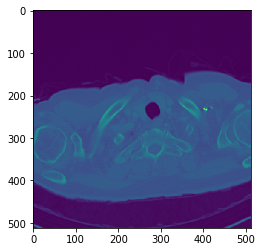

In [28]:
# Original image of slice0
C = slice0.pixel_array
plt.imshow(C)
plt.show()

1.0293632612956571e-10


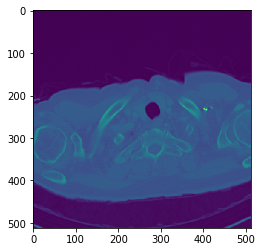

In [29]:
# Perform SVD and check that it is correctly done (original image is recovered)
u, s, v = np.linalg.svd(C)

Ck = np.matmul(np.matmul(u,np.diag(s)),v)
diff = C - Ck
print(np.max(diff))
plt.imshow(Ck)
plt.show()

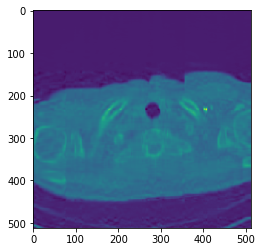

In [32]:
# Show image when rank is reduced to k
k = 20

importlib.reload(aux)
uk, sk, vk = aux.low_rank_C(u,s,v,k)
Ck = np.matmul(np.matmul(uk,np.diag(sk)),vk)
plt.imshow(Ck)
plt.show()

In order to choose a suitable $k$, we analyze the ratio $||C-C_k||_F/||C||_F$, where $||·||_F$ is the Frobenius norm, and the number of parameters required to store the reduced image. We look for a trade-off between low enough $||C-C_k||_F/||C||_F$ and low number of parameters:

In [31]:
importlib.reload(aux)

C_F = np.linalg.norm(C,'fro')
k_vec = [1,5,10,15,20,30,50,70,100,150,200,300,400,512]
err_vec = []
numparam_vec = []

for k in tqdm(k_vec):
    uk, sk, vk = aux.low_rank_C(u,s,v,k)
    Ck = np.matmul(np.matmul(uk,np.diag(sk)),vk)
    err = np.linalg.norm(C-Ck,'fro')/C_F
    err_vec.append(err)
    numparam = len(sk)+uk.shape[0]*uk.shape[1]+vk.shape[0]*vk.shape[1] # k+k*512+k*512
    numparam_vec.append(numparam)

print(k_vec[:8])
print(numparam_vec[:8])

100%|██████████| 14/14 [00:00<00:00, 139.63it/s]

[1, 5, 10, 15, 20, 30, 50, 70]
[1025, 5125, 10250, 15375, 20500, 30750, 51250, 71750]


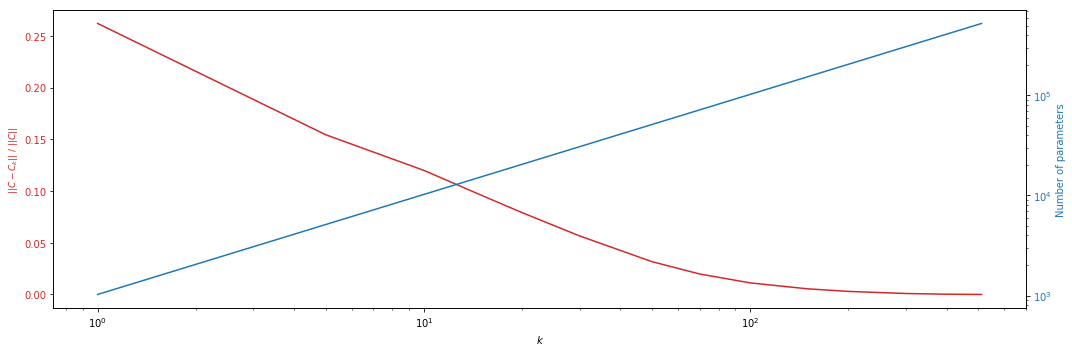

In [32]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
ax1.set_xscale('log')
ax1.set_xlabel('$k$')
ax1.set_ylabel('$||C-C_k||$ / $||C||$', fontsize=9, color=color)
ax1.plot(k_vec, err_vec, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_yscale('log')
ax2.set_ylabel('Number of parameters', color=color)  # we already handled the x-label with ax1
ax2.plot(k_vec, numparam_vec, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<font color='red'> FOR NOW, WE ARE NOT USING THE IMAGE AS A FEATURE.

In [33]:
feat = 'PixelData'
relev_feats.remove(feat)
print('<<'+feat+'>> removed.')

<<PixelData>> removed.


### Save relevant features

In [41]:
# Save relevant features
with open('data/relev_feats_NO_IMG.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(relev_feats, f)

## Save data in a useful format

First, we have to save in a variable(s) the data we will use in the project. Then, we will save this data in a file.
We work with each week data separately. Using the popular linear algebra notation ($Y=Xb$), we will construct two arrays for week $i$ called $Y_i$ and $X_i$, such that $Y = [Y_1, Y_2, ...]'\in\mathbb{R}^{n\times1}$ and $X = [X_1', X_2', ...]'\in\mathbb{R}^{n\times p}$, where $n$ is the total number of slices (samples) and $p$ is the number of feature values.

<font color='red'> FOR NOW, WE ARE NOT USING THE IMAGE AS A FEATURE.

In [5]:
# Load data
with open('data/relev_feats_NO_IMG.pickle','rb') as f:  # Python 3: open(..., 'rb')
    relev_feats = pickle.load(f)

In [6]:
# Compute p (it is not equal to the number of features, as some of them are multivalued;
# e.g. if we have a single feature that consists in two floats, it yields p=2)
importlib.reload(aux)
x = []

week = 1    
weekname = 'week'+str(week)+'data'
weekdata = eval(weekname)
slicce = week1data['E864M5E16Q'][0][1][0]
for feat in relev_feats:
    x = x+aux.get_feature_value(slicce,feat)
    
p = len(x)
print('Number of relevant features = ',len(relev_feats))
print('p = ',p)

Number of relevant features =  66
p =  136


In [7]:
importlib.reload(aux)

Y = np.empty((0,1))
X = np.empty((0,p))


for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    Yi = np.empty((0,1))
    Xi = np.empty((0,p))
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                Yi = np.append(Yi,[np.array([slicce.data_element('CTDIvol').value])],axis=0)
                x = []
                for feat in relev_feats:
                    x = x+aux.get_feature_value(slicce,feat)
                Xi = np.append(Xi,[np.array(x)],axis=0)
    Y = np.append(Y,Yi,axis=0)
    X = np.append(X,Xi,axis=0)

100%|██████████| 14/14 [01:16<00:00,  5.98s/it]


In [40]:
print(Y.shape)
print(X.shape)

# Divide data in two separate variables
Y12 = Y[:3800,:] # Y 1/2
Y22 = Y[3800:,:] # Y 2/2
print(Y12.shape)
print(Y22.shape)
print(Y22.shape[0]+Y12.shape[0])

X12 = X[:3800,:] # X 1/2
X22 = X[3800:,:] # X 2/2
print(X12.shape)
print(X22.shape)
print(X22.shape[0]+X12.shape[0])

(7787, 1)
(7787, 136)
(3800, 1)
(3987, 1)
7787
(3800, 136)
(3987, 136)
7787


In [41]:
# Save Y and X divided into 2 files. We do this in order to be able to upload them to
# Github, where the maximum file size is 100 Mb
with open('data/YX_12_NO_IMG.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([Y12,X12], f)
with open('data/YX_22_NO_IMG.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([Y22,X22], f)

## References

[1] DICOM tags: https://www.dicomlibrary.com/dicom/dicom-tags/

[2] DICOM UIDs: http://dicom.nema.org/dicom/2013/output/chtml/part05/chapter_9.html

[3] How to read DICOM files in Python: https://mscipio.github.io/post/read_dicom_files_in_python/

[4] General DICOM reference: https://www.dicomstandard.org/current/

[5] DICOM tags formats: http://dicom.nema.org/medical/dicom/current/output/pdf/part05.pdf

[6] Code Meaning: http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_8.3.html

[7] Working with PixelData: https://pydicom.github.io/pydicom/stable/working_with_pixel_data.html

[8] CTDIvol meaning: https://dicom.innolitics.com/ciods/ct-image/ct-image/00189345